In [1]:
import json
import itertools
import os
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.display import HTML
import subprocess

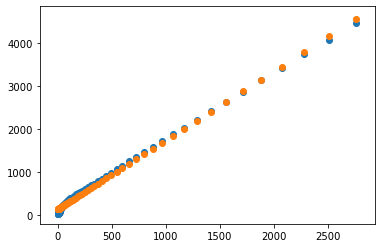

In [2]:
os.system("g++ -ffast-math -march=native -O3 measure_linvbin.cpp")
os.system("./a.out > bvl.csv")

df = pd.read_csv("bvl.csv", header=None, names=["method", "err", "time"])
df["time"] /= 500000


from scipy.stats import linregress
x = df[df.method == "linear"]["err"]
y = df[df.method == "linear"]["time"]

lslope, lintercept, lrval, _, _ = linregress(x, y)
def lin_mod(x):
    return (lslope * x + lintercept).clip(lower=0)

assert lrval > 0.98

plt.scatter(x, y)
plt.scatter(x, lin_mod(x))

0.9956172360330264


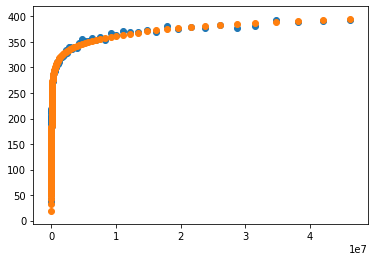

In [3]:
import numpy as np
x = df[df.method == "binary"]["err"]
y = df[df.method == "binary"]["time"]
slope, intercept, rval, _, _ = linregress(np.log(x), y)
print(rval)
def bin_mod(x):
    return (np.log(x) * slope + intercept).clip(lower=0)

plt.scatter(x, y)
plt.scatter(x, bin_mod(x))

In [12]:
from sklearn.neighbors import KNeighborsRegressor

bin_pred = KNeighborsRegressor(n_neighbors=2)
bin_pred.fit(df[df.method == "binary"][["err"]], df[df.method == "binary"]["time"])

lin_pred = KNeighborsRegressor(n_neighbors=2)
lin_pred.fit(df[df.method == "linear"][["err"]], df[df.method == "linear"]["time"])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [13]:
lin_pred.predict([[1]])
bin_pred.predict([[1]])

array([38.336445])

In [14]:
DATA_PATH = "/home/ryan/SOSD/data/osm_cellids_200M_uint64"
DATA_FILE = DATA_PATH.split("/")[-1]

os.system("cd .. && cargo build --release")
RMI_PATH = "../target/release/rmi"

In [15]:
top_only_layers = ["radix", "bradix"]
anywhere_layers = ["linear", "cubic"]
specialty_top_layers = ["histogram", "loglinear", "normal", "lognormal"]
branching_factors = [2**x for x in range(7, 22)]

In [16]:
all_top_layers = top_only_layers + anywhere_layers

In [17]:
# first, build a grid of the most likely configs
configs = []
nmspc_counter = 0
for top in all_top_layers:
    for bot in anywhere_layers:
        for bf in branching_factors[::3]:
            configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1
            
# next, build a few tests to see if a speciality layer would help
for top in specialty_top_layers:
    if top == "histogram":
        for bot in anywhere_layers:
            for bf in [64, 128, 256]:
                configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
                nmspc_counter += 1
    else:
        # not a histogram
        for bot in anywhere_layers:
            for bf in branching_factors[::4]:
                configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
                nmspc_counter += 1


In [18]:
def parallel_test_rmis(configs, threads=8, phase="", fast_top=False):
    if len(configs) < threads:
        threads = len(configs)
        
    os.system("rm *.json *.json_results")
    jobs = [[] for _ in range(threads)]
    procs = []
    
    for idx, conf in enumerate(configs):
        jobs[idx % threads].append(conf)
        
    for idx, workset in enumerate(jobs):
        fn = f"{phase}{idx}.json"
        with open(fn, "w") as f:
            json.dump({"configs": workset}, f)
        cmd = f"{RMI_PATH} {DATA_PATH} --param-grid {fn}"
        if fast_top:
            cmd += " --fast-top"
            
        procs.append(subprocess.Popen(cmd, shell=True))

    print("Spawned", threads, "processes with", [len(x) for x in jobs], "jobs each")
    
    for proc in procs:
        proc.wait()
        
    os.system("sync")
    os.system("rm -rf opt/")
    os.system("mkdir opt")
    os.system("mv nm* opt/")
    data = []
    for idx, _ in enumerate(jobs):
        fn = f"{phase}{idx}.json_results"
        with open(fn, "r") as f:
            data.extend(json.load(f))

    return data
    

In [19]:
print("Testing", len(configs), "initial configurations.")

step1_results = parallel_test_rmis(configs, phase="step1", fast_top=True)
step1_results = pd.DataFrame(step1_results)

Testing 70 initial configurations.
Spawned 8 processes with [9, 9, 9, 9, 9, 9, 8, 8] jobs each


In [20]:
display(HTML(step1_results.to_html()))

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,binary
0,"radix,linear",128,1.677722e+07,24.181279,48362559,24.181279,17536,16512,nm0,False
1,"radix,cubic",65536,6.498579e+04,0.340148,680296,0.340148,17301632,16777344,nm8,False
2,"bradix,cubic",1024,1.048576e+06,3.054265,6108530,3.054265,270528,262336,nm16,False
3,"linear,linear",524288,3.486324e+04,0.655730,1311459,0.655730,71303296,67108992,nm24,False
4,"cubic,linear",8192,1.616820e+05,1.255482,2510964,1.255482,1114368,1048832,nm32,False
5,"histogram,linear",64,6.011530e+05,1.308429,2616858,1.308429,67121792,67121280,nm40,False
6,"loglinear,linear",32768,9.175873e+04,0.945326,1890651,0.945326,4456576,4194432,nm48,False
7,"normal,linear",32768,5.487630e+04,0.652570,1305140,0.652570,4456640,4194496,nm56,False
8,"lognormal,linear",32768,5.242884e+05,2.513590,5027181,2.513590,4456640,4194496,nm64,False
9,"radix,linear",1024,1.167885e+06,2.812158,5624315,2.812158,139392,131200,nm1,False


In [21]:
import pystache
with open("bench.cpp", "r") as f:
    template = f.read()
    
with open("to_build.cpp", "w") as f:
    f.write(pystache.render(template, 
                            {"filename": DATA_PATH, 
                             "namespaces": step1_results.namespace.tolist()}))
    
if os.system("make -j 40") != 0:
    print("Error compiling inference program!")
    
os.system("./a.out > inference.txt")
with open("inference.txt") as f:
    inference = list(int(x.strip()[:-2]) / 100000.0 for x in f)
    
step1_results["inference"] = inference

In [22]:
step1_results["pred_time_lin"] = step1_results.inference + lin_pred.predict(step1_results[["max error"]])
step1_results["pred_time_bin"] = step1_results.inference + bin_pred.predict(step1_results[["max error"]])
step1_results["pred_time"] = step1_results[["pred_time_lin", "pred_time_bin"]].min(axis=1)
step1_results

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,binary,inference,pred_time_lin,pred_time_bin,pred_time
0,"radix,linear",128,1.677722e+07,24.181279,48362559,24.181279,17536,16512,nm0,False,23.01268,4306.270466,415.816139,415.816139
1,"radix,cubic",65536,6.498579e+04,0.340148,680296,0.340148,17301632,16777344,nm8,False,28.76951,4312.027296,329.605570,329.605570
2,"bradix,cubic",1024,1.048576e+06,3.054265,6108530,3.054265,270528,262336,nm16,False,26.62978,4309.887566,381.188837,381.188837
3,"linear,linear",524288,3.486324e+04,0.655730,1311459,0.655730,71303296,67108992,nm24,False,51.08490,4334.342686,368.364317,368.364317
4,"cubic,linear",8192,1.616820e+05,1.255482,2510964,1.255482,1114368,1048832,nm32,False,27.45768,4310.715466,361.462583,361.462583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,"cubic,linear",1024,1.048576e+06,1.680674,3361348,1.680674,139520,131328,nm31,False,24.65568,4307.913466,362.216684,362.216684
66,"cubic,cubic",524288,1.013130e+04,0.053705,107409,0.053705,138412288,134217984,nm39,False,57.90848,4341.166266,318.354204,318.354204
67,"loglinear,linear",2048,1.244581e+06,3.164984,6329968,3.164984,278656,262272,nm47,False,30.56950,4313.827286,385.814910,385.814910
68,"normal,linear",2048,2.621440e+05,1.119526,2239053,1.119526,278720,262336,nm55,False,35.34790,4318.605686,366.711743,366.711743


In [23]:
def pareto_mask(df, v1="size linear search", v2="pred_time", soft=True):
    # find Pareto efficient RMIs
    mask = []
    for idx1, el1 in df.iterrows():
        my_size = el1[v1]
        my_time = el1[v2]
        for idx2, el2 in df.iterrows():
            if idx1 == idx2:
                continue

            if ((el2[v1] <= my_size) 
                and (el2[v2] <= my_time - (5 if soft else 0))):
                mask.append(False)
                break
        else:
            mask.append(True)
    return mask

In [24]:
mask = pareto_mask(step1_results)
pareto = step1_results[mask]
print("Found", len(pareto), "Pareto efficient models")
display(HTML(pareto.to_html()))

Found 38 Pareto efficient models


,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,binary,inference,pred_time_lin,pred_time_bin,pred_time
0,"radix,linear",128,1.677722e+07,24.181279,48362559,24.181279,17536,16512,nm0,False,23.01268,4306.270466,415.816139,415.816139
1,"radix,cubic",65536,6.498579e+04,0.340148,680296,0.340148,17301632,16777344,nm8,False,28.76951,4312.027296,329.605570,329.605570
2,"bradix,cubic",1024,1.048576e+06,3.054265,6108530,3.054265,270528,262336,nm16,False,26.62978,4309.887566,381.188837,381.188837
6,"loglinear,linear",32768,9.175873e+04,0.945326,1890651,0.945326,4456576,4194432,nm48,False,33.30968,4316.567466,356.130193,356.130193
7,"normal,linear",32768,5.487630e+04,0.652570,1305140,0.652570,4456640,4194496,nm56,False,40.01076,4323.268546,357.290177,357.290177
9,"radix,linear",1024,1.167885e+06,2.812158,5624315,2.812158,139392,131200,nm1,False,21.70757,4304.965356,373.771957,373.771957
10,"radix,cubic",524288,1.730993e+04,0.121467,242934,0.121467,138412160,134217856,nm9,False,33.20807,4316.465856,312.160063,312.160063
11,"bradix,cubic",8192,2.070143e+05,1.149582,2299165,1.149582,2162880,2097344,nm17,False,26.31064,4309.568426,357.674483,357.674483
12,"linear,cubic",128,2.097152e+06,3.515454,7030908,3.515454,33920,32896,nm25,False,30.11912,4313.376906,386.595406,386.595406
13,"cubic,linear",65536,4.470025e+04,0.379772,759544,0.379772,8913152,8388864,nm33,False,31.12193,4314.379716,333.709306,333.709306


In [25]:
candidate_layers = set(pareto["layers"])
next_configs = []
for candidate in candidate_layers:
    if candidate.startswith("histogram"):
        for bf in [32, 300, 512]:
            next_configs.append({"layers": candidate, "branching factor": bf,
                                 "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1

    else:
        already_known = step1_results[step1_results.layers == candidate]["branching factor"].to_list()
        for bf in sorted(set(branching_factors) - set(already_known)):
            next_configs.append({"layers": candidate, "branching factor": bf,
                                 "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1

In [26]:
print("Testing", len(next_configs), "additional configurations.")

step2_results = parallel_test_rmis(next_configs, phase="step2", fast_top=True)
step2_results = pd.DataFrame(step2_results)

Testing 124 additional configurations.
Spawned 8 processes with [16, 16, 16, 16, 15, 15, 15, 15] jobs each


In [27]:
import pystache
with open("bench.cpp", "r") as f:
    template = f.read()
    
with open("to_build.cpp", "w") as f:
    f.write(pystache.render(template, 
                            {"filename": DATA_PATH, 
                             "namespaces": step2_results.namespace.tolist()}))
    

In [28]:
print("Compiling...")
os.system("make -j 40")

print("Executing...")
os.system("./a.out > inference.txt")
with open("inference.txt") as f:
    inference = list(int(x.strip()[:-2]) / 100000.0 for x in f)
    
step2_results["inference"] = inference

Compiling...
Executing...


In [29]:
step2_results["pred_time_lin"] = step2_results.inference + lin_pred.predict(step2_results[["max error"]])
step2_results["pred_time_bin"] = step2_results.inference + bin_pred.predict(step2_results[["max error"]])
step2_results["pred_time"] = step2_results[["pred_time_lin", "pred_time_bin"]].min(axis=1)
step2_results

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,binary,inference,pred_time_lin,pred_time_bin,pred_time
0,"linear,cubic",256,1.443790e+06,3.054418,6108835,3.054418,67712,65664,nm70,False,33.63305,4316.890836,388.192107,388.192107
1,"linear,cubic",1048576,3.965471e+04,1.237624,2475249,1.237624,276824192,268435584,nm78,False,70.48693,4353.744716,404.491833,404.491833
2,"bradix,linear",131072,2.785320e+04,0.235951,471902,0.235951,17825984,16777408,nm86,False,29.42980,4312.687586,323.470237,323.470237
3,"loglinear,cubic",8192,2.621440e+05,0.769680,1539360,0.769680,2162816,2097280,nm94,False,37.35010,4320.607886,357.781684,357.781684
4,"bradix,cubic",512,1.048576e+06,3.643267,7286535,3.643267,135360,131264,nm102,False,25.55056,4308.808346,382.026846,382.026846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,"radix,cubic",16384,2.070143e+05,1.149582,2299165,1.149582,4325504,4194432,nm157,False,25.15153,4308.409316,356.515373,356.515373
120,"loglinear,linear",1024,2.778780e+06,3.221542,6443085,3.221542,139392,131200,nm165,False,30.01491,4313.272696,385.260320,385.260320
121,"loglinear,linear",2097152,1.026091e+04,0.199577,399154,0.199577,285212800,268435584,nm173,False,60.94868,4344.206466,354.306458,354.306458
122,"cubic,cubic",262144,1.834619e+04,0.075484,150969,0.075484,69206272,67109120,nm181,False,48.06275,4331.320536,315.408724,315.408724


In [30]:
all_results = pd.concat((step1_results, step2_results)).reset_index(drop=True)
mask = pareto_mask(all_results)
all_results.sort_values("pred_time")

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,binary,inference,pred_time_lin,pred_time_bin,pred_time
129,"radix,cubic",1048576,8.606034e+03,0.041092,82184,0.041092,276824192,268435584,nm161,False,37.52333,4320.781116,295.001843,295.001843
29,"bradix,cubic",524288,8.606034e+03,0.041092,82184,0.041092,138412224,134217920,nm19,False,38.56990,4321.827686,296.048413,296.048413
145,"radix,cubic",2097152,6.727618e+03,0.049624,99248,0.049624,553648256,536871040,nm162,False,41.72551,4324.983296,299.786212,299.786212
75,"bradix,cubic",2097152,3.758443e+03,0.028230,56459,0.028230,553648320,536871104,nm110,False,52.10804,4335.365826,300.499689,300.499689
183,"bradix,cubic",1048576,6.727618e+03,0.049624,99248,0.049624,276824256,268435648,nm109,False,44.01888,4327.276666,302.079582,302.079582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,"lognormal,cubic",32768,8.622724e+05,2.931401,5862803,2.931401,8650944,8388800,nm68,False,63.56209,4346.819876,418.121147,418.121147
35,"lognormal,cubic",2048,2.097152e+06,8.319859,16639719,8.319859,540864,524480,nm67,False,61.13215,4344.389936,437.006349,437.006349
69,"lognormal,linear",2048,4.194304e+06,15.417554,30835109,15.417554,278720,262336,nm63,False,60.08133,4343.339116,439.652623,439.652623
61,"lognormal,linear",128,1.047777e+07,17.164194,34328388,17.164194,17600,16576,nm62,False,56.73019,4339.987976,443.991590,443.991590


In [31]:
display(HTML(all_results.sort_values("pred_time").to_html()))

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,binary,inference,pred_time_lin,pred_time_bin,pred_time
129,"radix,cubic",1048576,8.606034e+03,0.041092,82184,0.041092,276824192,268435584,nm161,False,37.52333,4320.781116,295.001843,295.001843
29,"bradix,cubic",524288,8.606034e+03,0.041092,82184,0.041092,138412224,134217920,nm19,False,38.56990,4321.827686,296.048413,296.048413
145,"radix,cubic",2097152,6.727618e+03,0.049624,99248,0.049624,553648256,536871040,nm162,False,41.72551,4324.983296,299.786212,299.786212
75,"bradix,cubic",2097152,3.758443e+03,0.028230,56459,0.028230,553648320,536871104,nm110,False,52.10804,4335.365826,300.499689,300.499689
183,"bradix,cubic",1048576,6.727618e+03,0.049624,99248,0.049624,276824256,268435648,nm109,False,44.01888,4327.276666,302.079582,302.079582
96,"radix,linear",1048576,8.192000e+03,0.104105,208211,0.104105,142606464,134217856,nm151,False,31.32367,4314.581456,306.572464,306.572464
55,"bradix,linear",524288,8.192000e+03,0.104105,208211,0.104105,71303360,67109056,nm14,False,33.75954,4317.017326,309.008334,309.008334
10,"radix,cubic",524288,1.730993e+04,0.121467,242934,0.121467,138412160,134217856,nm9,False,33.20807,4316.465856,312.160063,312.160063
168,"bradix,cubic",262144,1.730993e+04,0.121467,242934,0.121467,69206208,67109056,nm108,False,34.78461,4318.042396,313.736603,313.736603
192,"cubic,cubic",262144,1.834619e+04,0.075484,150969,0.075484,69206272,67109120,nm181,False,48.06275,4331.320536,315.408724,315.408724


In [32]:
def human_size(bytes, units=[' bytes','KB','MB','GB','TB', 'PB', 'EB']):
    """ Returns a human readable string reprentation of bytes"""
    return str(bytes) + units[0] if bytes < 1024 else human_size(bytes>>10, units[1:])

all_hresults = all_results.copy()
all_hresults["size linear search"] = [human_size(x) for x in all_results["size linear search"].to_list()]
all_hresults["size binary search"] = [human_size(x) for x in all_results["size binary search"].to_list()]
all_hresults[mask].sort_values("pred_time")

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,binary,inference,pred_time_lin,pred_time_bin,pred_time
129,"radix,cubic",1048576,8.606034e+03,0.041092,82184,0.041092,264MB,256MB,nm161,False,37.52333,4320.781116,295.001843,295.001843
29,"bradix,cubic",524288,8.606034e+03,0.041092,82184,0.041092,132MB,128MB,nm19,False,38.56990,4321.827686,296.048413,296.048413
145,"radix,cubic",2097152,6.727618e+03,0.049624,99248,0.049624,528MB,512MB,nm162,False,41.72551,4324.983296,299.786212,299.786212
75,"bradix,cubic",2097152,3.758443e+03,0.028230,56459,0.028230,528MB,512MB,nm110,False,52.10804,4335.365826,300.499689,300.499689
183,"bradix,cubic",1048576,6.727618e+03,0.049624,99248,0.049624,264MB,256MB,nm109,False,44.01888,4327.276666,302.079582,302.079582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,"bradix,linear",128,6.668574e+06,10.719710,21439421,10.719710,17KB,16KB,nm10,False,23.27824,4306.536026,400.943803,400.943803
45,"radix,cubic",128,8.388608e+06,14.061114,28122228,14.061114,33KB,32KB,nm5,False,22.39272,4305.650506,402.989204,402.989204
59,"loglinear,linear",128,4.194304e+06,11.555172,23110345,11.555172,17KB,16KB,nm46,False,29.24619,4312.503976,408.511067,408.511067
60,"normal,linear",128,2.097152e+06,8.961448,17922897,8.961448,17KB,16KB,nm54,False,34.47011,4317.727896,412.824067,412.824067


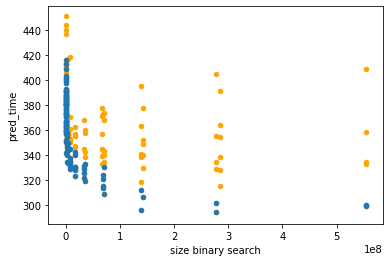

In [33]:
ax = all_results.plot.scatter("size binary search", "pred_time", color="orange")
all_results[mask].plot.scatter("size binary search", "pred_time", ax=ax)

In [34]:
all_results["binary"] = all_results["pred_time_lin"] >= all_results["pred_time_bin"]

final_configs = []
for idx, row in all_results[mask][["layers", "branching factor", "namespace", "binary"]].iterrows():
    final_configs.append(row.to_dict())
                         
final_results = parallel_test_rmis(final_configs, phase="step3")

Spawned 8 processes with [13, 13, 13, 13, 12, 12, 12, 12] jobs each


In [37]:
os.system("rm -rf SOSD/competitors/rmi/nm*")
for idx, r in all_results[mask].iterrows():
    ns = r["namespace"]
    os.system(f"cp opt/{ns}.cpp SOSD/competitors/rmi/")
    os.system(f"cp opt/{ns}_data.h SOSD/competitors/rmi/")
    os.system(f"cp opt/{ns}.h SOSD/competitors/rmi/")

In [38]:
with open("SOSD/benchmark.cc.mustache", "r") as f:
    template = f.read()
    
with open("SOSD/benchmark.cc", "w") as f:
    f.write(pystache.render(template, 
                            {"candidates": final_configs}))
    
os.system("cd SOSD && scripts/prepare.sh")
os.system(f"cd SOSD && build/benchmark {DATA_PATH} {DATA_PATH}_equality_lookups_10M > times.txt")

0

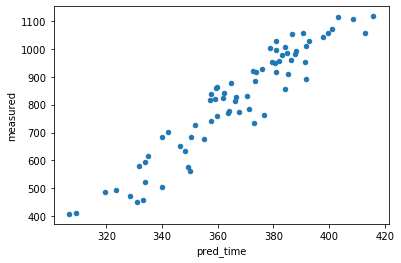

In [39]:
times = []
with open("SOSD/times.txt", "r") as f:
    for l in f:
        if not l.startswith("RESULT"):
            continue
        if "," not in l:
            continue
        result = l.split(",")[1]
        if result == "-1":
            times.append(float("NaN"))
        else:
            times.append(float(result))
        
tested_results = all_results[mask].copy()
tested_results["measured"] = times
tested_results.plot.scatter("pred_time", "measured")

In [49]:
failed_mask = tested_results["measured"].isna()
tested_results[failed_mask][["layers", "branching factor"]]

,layers,branching factor
1,"radix,cubic",65536
10,"radix,cubic",524288
20,"bradix,cubic",65536
29,"bradix,cubic",524288
42,"loglinear,cubic",32768
43,"normal,cubic",32768
49,"cubic,cubic",8192
58,"cubic,cubic",65536
75,"bradix,cubic",2097152
81,"radix,cubic",32768


,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,binary,inference,pred_time_lin,pred_time_bin,pred_time,measured
96,"radix,linear",1048576,8.192000e+03,0.104105,208211,0.104105,142606464,134217856,nm151,True,31.32367,4314.581456,306.572464,306.572464,407.269
55,"bradix,linear",524288,8.192000e+03,0.104105,208211,0.104105,71303360,67109056,nm14,True,33.75954,4317.017326,309.008334,309.008334,412.014
36,"radix,linear",524288,1.767429e+04,0.371465,742930,0.371465,71303296,67108992,nm4,True,28.35753,4311.615316,330.944906,330.944906,451.667
88,"bradix,linear",262144,1.767429e+04,0.371465,742930,0.371465,35651776,33554624,nm87,True,30.55099,4313.808776,333.138366,333.138366,456.840
85,"cubic,linear",131072,2.488985e+04,0.245839,491678,0.245839,17826048,16777472,nm190,True,33.98436,4317.242146,328.558556,328.558556,471.738
72,"bradix,linear",131072,2.785320e+04,0.235951,471902,0.235951,17825984,16777408,nm86,True,29.42980,4312.687586,323.470237,323.470237,493.763
13,"cubic,linear",65536,4.470025e+04,0.379772,759544,0.379772,8913152,8388864,nm33,True,31.12193,4314.379716,333.709306,333.709306,522.478
193,"cubic,linear",32768,9.526348e+04,0.878130,1756259,0.878130,4456704,4194560,nm189,True,28.49265,4311.750436,349.992490,349.992490,560.634
169,"linear,linear",32768,7.640037e+04,0.655866,1311732,0.655866,4456576,4194432,nm116,True,32.10725,4315.365036,349.386667,349.386667,576.994
178,"cubic,linear",16384,1.002214e+05,0.505767,1011534,0.505767,2228480,2097408,nm188,True,27.01782,4310.275606,334.986193,334.986193,616.079


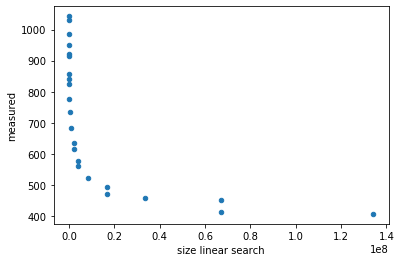

In [50]:
final_mask = pareto_mask(tested_results, v2="measured", soft=False)
tested_results[final_mask].plot.scatter("size linear search", "measured")
tested_results[final_mask].sort_values("measured")